In [1]:
using Gen
using Plots
using Pkg
Pkg.activate("myenv")
#Pkg.add("ForwardDiff")
using ForwardDiff

  Activating project at `~/Algorithms-of-the-Mind/lectures/lecture-13/myenv`


In [2]:
f(x) = x^2

f (generic function with 1 method)

In [3]:
ForwardDiff.derivative(f, 1.0)

2.0

In [4]:
ϵ = 0.1
(f(1 + ϵ) - f(1))/ϵ

2.100000000000002

In [5]:
g((x,y)) = x + y + x * y

g (generic function with 1 method)

In [6]:
ForwardDiff.gradient(g, [1, 2])

2-element Vector{Int64}:
 3
 2

In [7]:
begin
    ∂g∂x = (g([1 + ϵ, 2]) - g([1, 2]))/ϵ
    ∂g∂y = (g([1, 2 + ϵ]) - g([1, 2]))/ϵ
    ∇g = [∂g∂x, ∂g∂y]
end

2-element Vector{Float64}:
 3.000000000000007
 2.0000000000000018

## Trainable parameters example

Here is a generative function with a few parameters and a couple of random variables

In [17]:
@gen function model_fixed_params()
    x_mu::Float64 = 1.0
    a::Float64 = 1.5
    b::Float64 = 0.7
    x ~ normal(x_mu, 1.)
    y ~ normal(a * x + b, 1.)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##model_fixed_params#295", Bool[], false)

In [27]:
function visualize(model)
    xs = zeros(100)::Vector{Float64}
    ys = zeros(100)::Vector{Float64}
    for k in 1:100
        trace = Gen.simulate(model, ())
        xs[k] = trace[:x]
        ys[k] = trace[:y]
    end
    scatter(xs, ys, labels=:none, thickness_scaling=3.5, size=(1600, 1600))
end

visualize (generic function with 1 method)

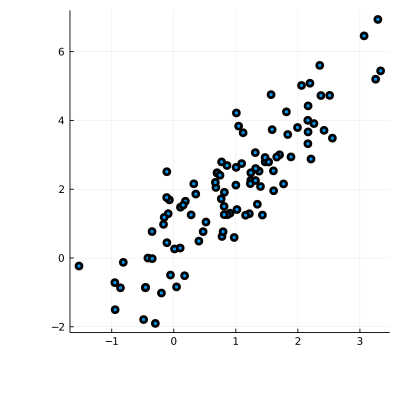

In [28]:
visualize(model_fixed_params)

Let's define a generative model with *trainable* parameters.

In [38]:
@gen function model_trainable()
    @param center::Float64
    @param a::Float64
    @param b::Float64
    x ~ normal(center, 1.)
    y ~ normal(a * x + b, 1.)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##model_trainable#306", Bool[], false)

## Learning procedure

Learning procedure consists of these steps.

- Initialization of parameters
- Data loader
- Choice of the optimizer
- Training

In [5]:
function data_generator()
    dgp_trace = Gen.simulate(model_fixed_params, ())
    constraints = Gen.choicemap()
    constraints[:x] = dgp_trace[:x]
    constraints[:y] = dgp_trace[:y]
    return ((), constraints)
end

data_generator (generic function with 1 method)

In [39]:
function train_model(dataset)
    init_param!(model_trainable, :a, 0.1)
    init_param!(model_trainable, :b, 0.1)
    init_param!(model_trainable, :center, 0.1)
    max_iter = 100
    loss = []
    update = ParamUpdate(FixedStepGradientDescent(0.001), model_trainable)
    for iter=1:max_iter
        objective = 0
        for k in 1:100
            item = dataset[k]
            trace, _ = Gen.generate(model_trainable, (), item)
            objective += get_score(trace) 
            accumulate_param_gradients!(trace)
        end
        push!(loss, objective)
        apply!(update)
    end
    return loss
end

train_model (generic function with 2 methods)

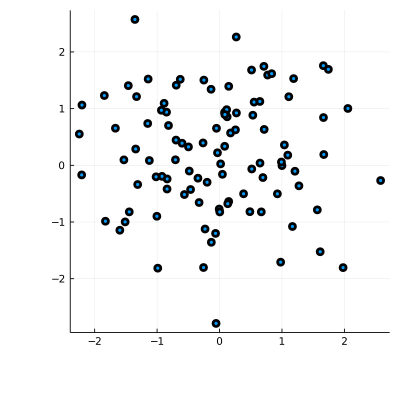

In [40]:
init_param!(model_trainable, :a, 0.1)
init_param!(model_trainable, :b, 0.1)
init_param!(model_trainable, :center, 0.1)
visualize(model_trainable)

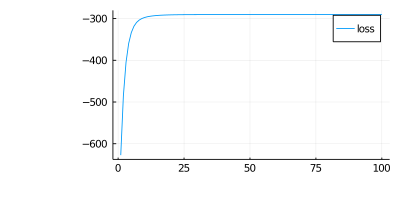

In [41]:
dataset = []
for k in 1:100
    _, item = data_generator()
    push!(dataset, item)
end
loss = train_model(dataset)
plot(loss, labels="loss", thickness_scaling=3.5, size=(1600, 800))

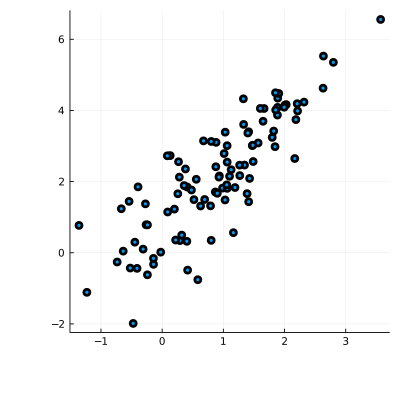

In [42]:
visualize(model_trainable)